# Linear Transformation 
We will start with the alignement of the same models for different seeds. 
- First we do not restrict the matrix.
- Second we restrict the matrix to be a rotation matrix.
- Thrid use affine transformation 
- Last but not least we are using different norms and regularization techniques to improve the results



Steps: 
- Load the same model but with different seed
- Sample different images and get latent representation 
- Create Datamatrix X and X'
- Solve the simple optimization problem


In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from sklearn.decomposition import PCA


/Users/federicoferoggio/Documents/vs_code/latent-communication/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration

config = {
    'path1': "/Users/federicoferoggio/Documents/vs_code/latent-communication/Pretrained_models/LightningAutoencoder_1.ckpt",
    'modelname1': 'AE1',
    'path2': "/Users/federicoferoggio/Documents/vs_code/latent-communication/Pretrained_models/LightningAutoencoder_1.ckpt",
    'modelname2': 'AE2',

}

# Optimization Problem in the Linear Case 
Let $x^i,y^i \in \mathbb{R^n}$ for $i = 1,...,m$ and $A \in \mathbb{R}^{n \times n}$ we are looking for the optimal A, which solves the following optimization problem 
$$ min_A \sum_{i = 1}^n ||Ax^i - y^i||^2 $$
where we are using the euclidian norm when not otherwise stated.



## Load Model and Transformed Data for VAE

In [3]:
# get working directory
import os
# Change directory
os.chdir('/Users/federicoferoggio/Documents/vs_code/latent-communication/')

# Import Data 
from helper.DataLoaderMNIST import DataLoader_MNIST

# Transdormations
transformations = [transforms.ToTensor(), 
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,)),
                                # Flatten the Image to a vector
                                transforms.Lambda(lambda x: x.view(-1) )
                                ]
# Load the data
data_loader = DataLoader_MNIST(128, transformations)

from AE.model_def import LightningAutoencoder

# Initialize the models
model1 = LightningAutoencoder()

# Load pretrained weights for model1
model1 = LightningAutoencoder.load_from_checkpoint(checkpoint_path=config['path1'])
# Initialize the model 2
model2 = LightningAutoencoder()
# Load pretrained weights for model2
model2 = LightningAutoencoder.load_from_checkpoint(checkpoint_path=config['path2'])

## Sampling 
We sample images from the train set and encode those for each model 

In [4]:
# Sample Size 
m = 100

# Sample images from train set 
images, _ = next(iter(data_loader.train_loader))


images = images.view(images.size(0), 1, 28, 28)
#
z1 = model1.getLatenSpace(images)
z2 = model2.getLatenSpace(images)

print(z1.shape)
print(z2.shape)
# Detach from GPU
z1 = z1.detach().cpu().numpy()
z2 = z2.detach().cpu().numpy()  

torch.Size([128, 500])
torch.Size([128, 500])


# Calulate optimal matrix 

(128, 500)
81.9060354720692


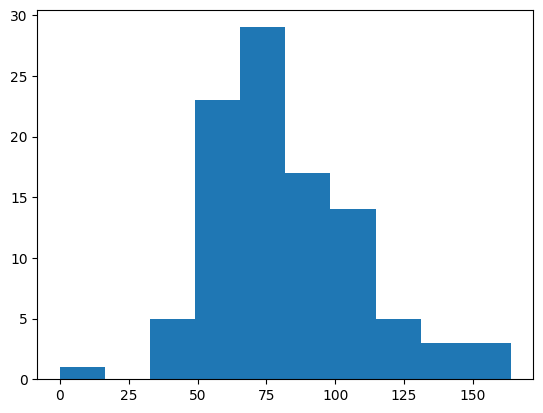

In [13]:
# Regularization 
lamda = 0.0001

print(z1.shape)
# Get the dimensions of the latent space
d = z1.shape[1]

# Initialize the matrices
M = np.zeros((d, d))
L = np.zeros((d, d))

# Compute the matrices
for i in range(d):
    M = M + np.outer(z1[1, :], z2[1, :])
    L = L + np.outer(z1[1, :], z2[1, :])

# Compute the optimal regularized matrix
A = L @ np.linalg.inv(M + lamda * np.eye(d))

# Compute distance
distance = np.zeros(m)
for i in range(m):
    distance[i] = np.linalg.norm(A @ z1[i, :] - z2[i, :])

# Plot the distance
plt.hist(distance)

# Overall Loss 
overall_loss = np.mean(distance)
print(overall_loss)

(60000, 500)
(60000,)


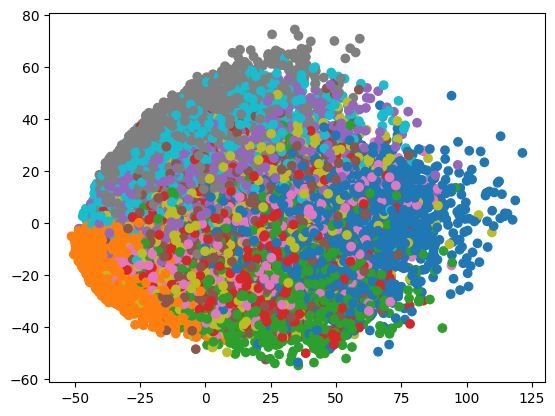

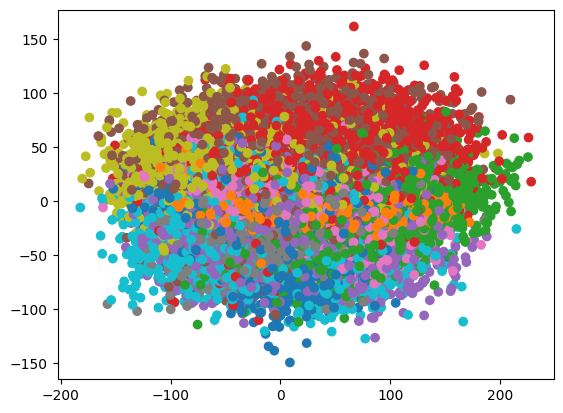

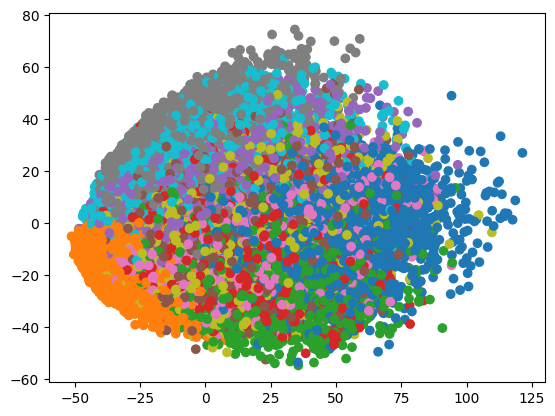

In [16]:

# Latent Space
latent_spaces = []
latent_spaces2 = []
all_labels = []

# Iterate through all batches in train_loader
for images, labels in data_loader.train_loader:
    images = images.view(images.size(0), 1, 28, 28)
    latent_space = model1.getLatenSpace(images)
    latent_space2 = model2.getLatenSpace(images)
    latent_spaces.append(latent_space.cpu().detach().numpy())
    latent_spaces2.append(latent_space2.cpu().detach().numpy())
    all_labels.append(labels.numpy())

# Concatenate latent space representations from all batches
latent_space = np.concatenate(latent_spaces, axis=0)
latent_space2 = np.concatenate(latent_spaces2, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


print(latent_space.shape)
print(all_labels.shape)



# Plot latent space via PCA
pca = PCA(n_components=2)


latent_space_pca = pca.fit_transform(latent_space)

# Plot the latent space
plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot)

# Transform the latent space
latent_space_transformed = np.dot(latent_space, A.T)
# Plot latent space via PCA
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_transformed)

# Plot the latent space
plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot)


# Plot the second latent space
latent_space_pca2 = pca.fit_transform(latent_space2)

pca_second = PCA(n_components=2)
plot_second = plt.scatter(latent_space_pca2[:, 0], latent_space_pca2[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot_second)